In [22]:
# Imports
from lib.utils import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn.functional import relu,one_hot,softmax
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from lib.models import CNN_0

device = 'cuda'
torch.cuda.empty_cache()

In [23]:
X,y = load_raw_list([20])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,shuffle=True,stratify=y,random_state=0)
X_train = X_train.reshape(-1,1,5000)
X_test = X_test.reshape(-1,1,5000)
y_train_one_hot = one_hot(y_train,num_classes=3).reshape(-1,3).float()
y_test_one_hot = one_hot(y_test,num_classes=3).reshape(-1,3).float()
train_dataloader = DataLoader(TensorDataset(X_train,y_train_one_hot), batch_size=256, shuffle=True)
test_dataloader = DataLoader(TensorDataset(X_test,y_test_one_hot), batch_size=256, shuffle=False)

In [24]:
model = CNN_0().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
train_losses = []
test_losses = []
model(X_train[0].cuda()).shape

Parameter containing:
tensor([0.1000, 1.0000, 1.0000], requires_grad=True)


torch.Size([1, 3])

In [25]:
training_loss = 0
model.train()
for (X,y) in train_dataloader:
    X,y = X.to(device), y.to(device)
    logits = model(X)
    loss = criterion(logits,y)
    training_loss += loss.item()
training_loss/len(train_dataloader)

0.9255129407953333

In [32]:
for epoch in range(200):
    training_loss = 0
    model.train()
    for (X,y) in train_dataloader:
        X,y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    # if(epoch%10 == 0):
    train_losses.append(training_loss/len(train_dataloader))
    model.eval()
    testing_loss = 0
    for (X,y) in test_dataloader:
        X,y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits,y)
        testing_loss += loss.item()
    test_losses.append(testing_loss/len(test_dataloader))
    print(f'Epoch {epoch} Train: {training_loss/len(train_dataloader)} Test: {testing_loss/len(test_dataloader)}')
    plt.plot(train_losses[-100:],label='train')
    plt.plot(test_losses[-100:],label='validation')
    plt.savefig('loss.jpg',dpi=200)
    plt.close()

Epoch 0 Train: 0.18825647400485146 Test: 0.31599935037749155
Epoch 1 Train: 0.18817699893757148 Test: 0.3167843839951924
Epoch 2 Train: 0.18567790063443007 Test: 0.29382431719984325
Epoch 3 Train: 0.18687442303807647 Test: 0.29543847909995485
Epoch 4 Train: 0.18873564512641341 Test: 0.2973313054868153
Epoch 5 Train: 0.18459589117103153 Test: 0.2918118174586977
Epoch 6 Train: 0.1817225123997088 Test: 0.31627383828163147
Epoch 7 Train: 0.19453049533896977 Test: 0.290500032050269
Epoch 8 Train: 0.18596061733033922 Test: 0.3016309567860195
Epoch 9 Train: 0.1906616050336096 Test: 0.2931194539581026
Epoch 10 Train: 0.18265879650910696 Test: 0.2906374271426882
Epoch 11 Train: 0.18205815277717732 Test: 0.29365573823451996
Epoch 12 Train: 0.18169698119163513 Test: 0.3104663150651114
Epoch 13 Train: 0.18634495249500982 Test: 0.3085769712924957
Epoch 14 Train: 0.1975603042929261 Test: 0.3101976386138371
Epoch 15 Train: 0.18654074492277922 Test: 0.30165987993989674
Epoch 16 Train: 0.18911187847455

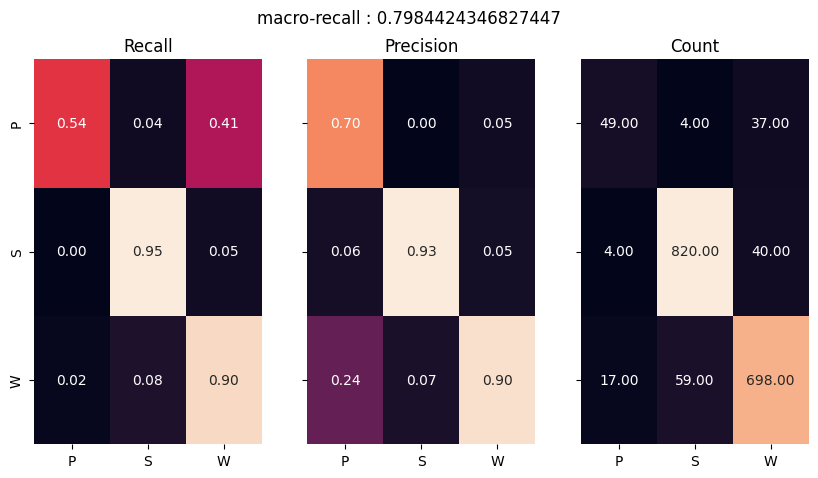

In [30]:
y_pred = torch.Tensor().cuda()
for (X,_) in test_dataloader:
    y_pred = torch.cat([y_pred,softmax(model(X.cuda()),dim=1).argmax(axis=1)])
y_pred = y_pred.cpu()

cms(y_true=y_test,y_pred=y_pred)

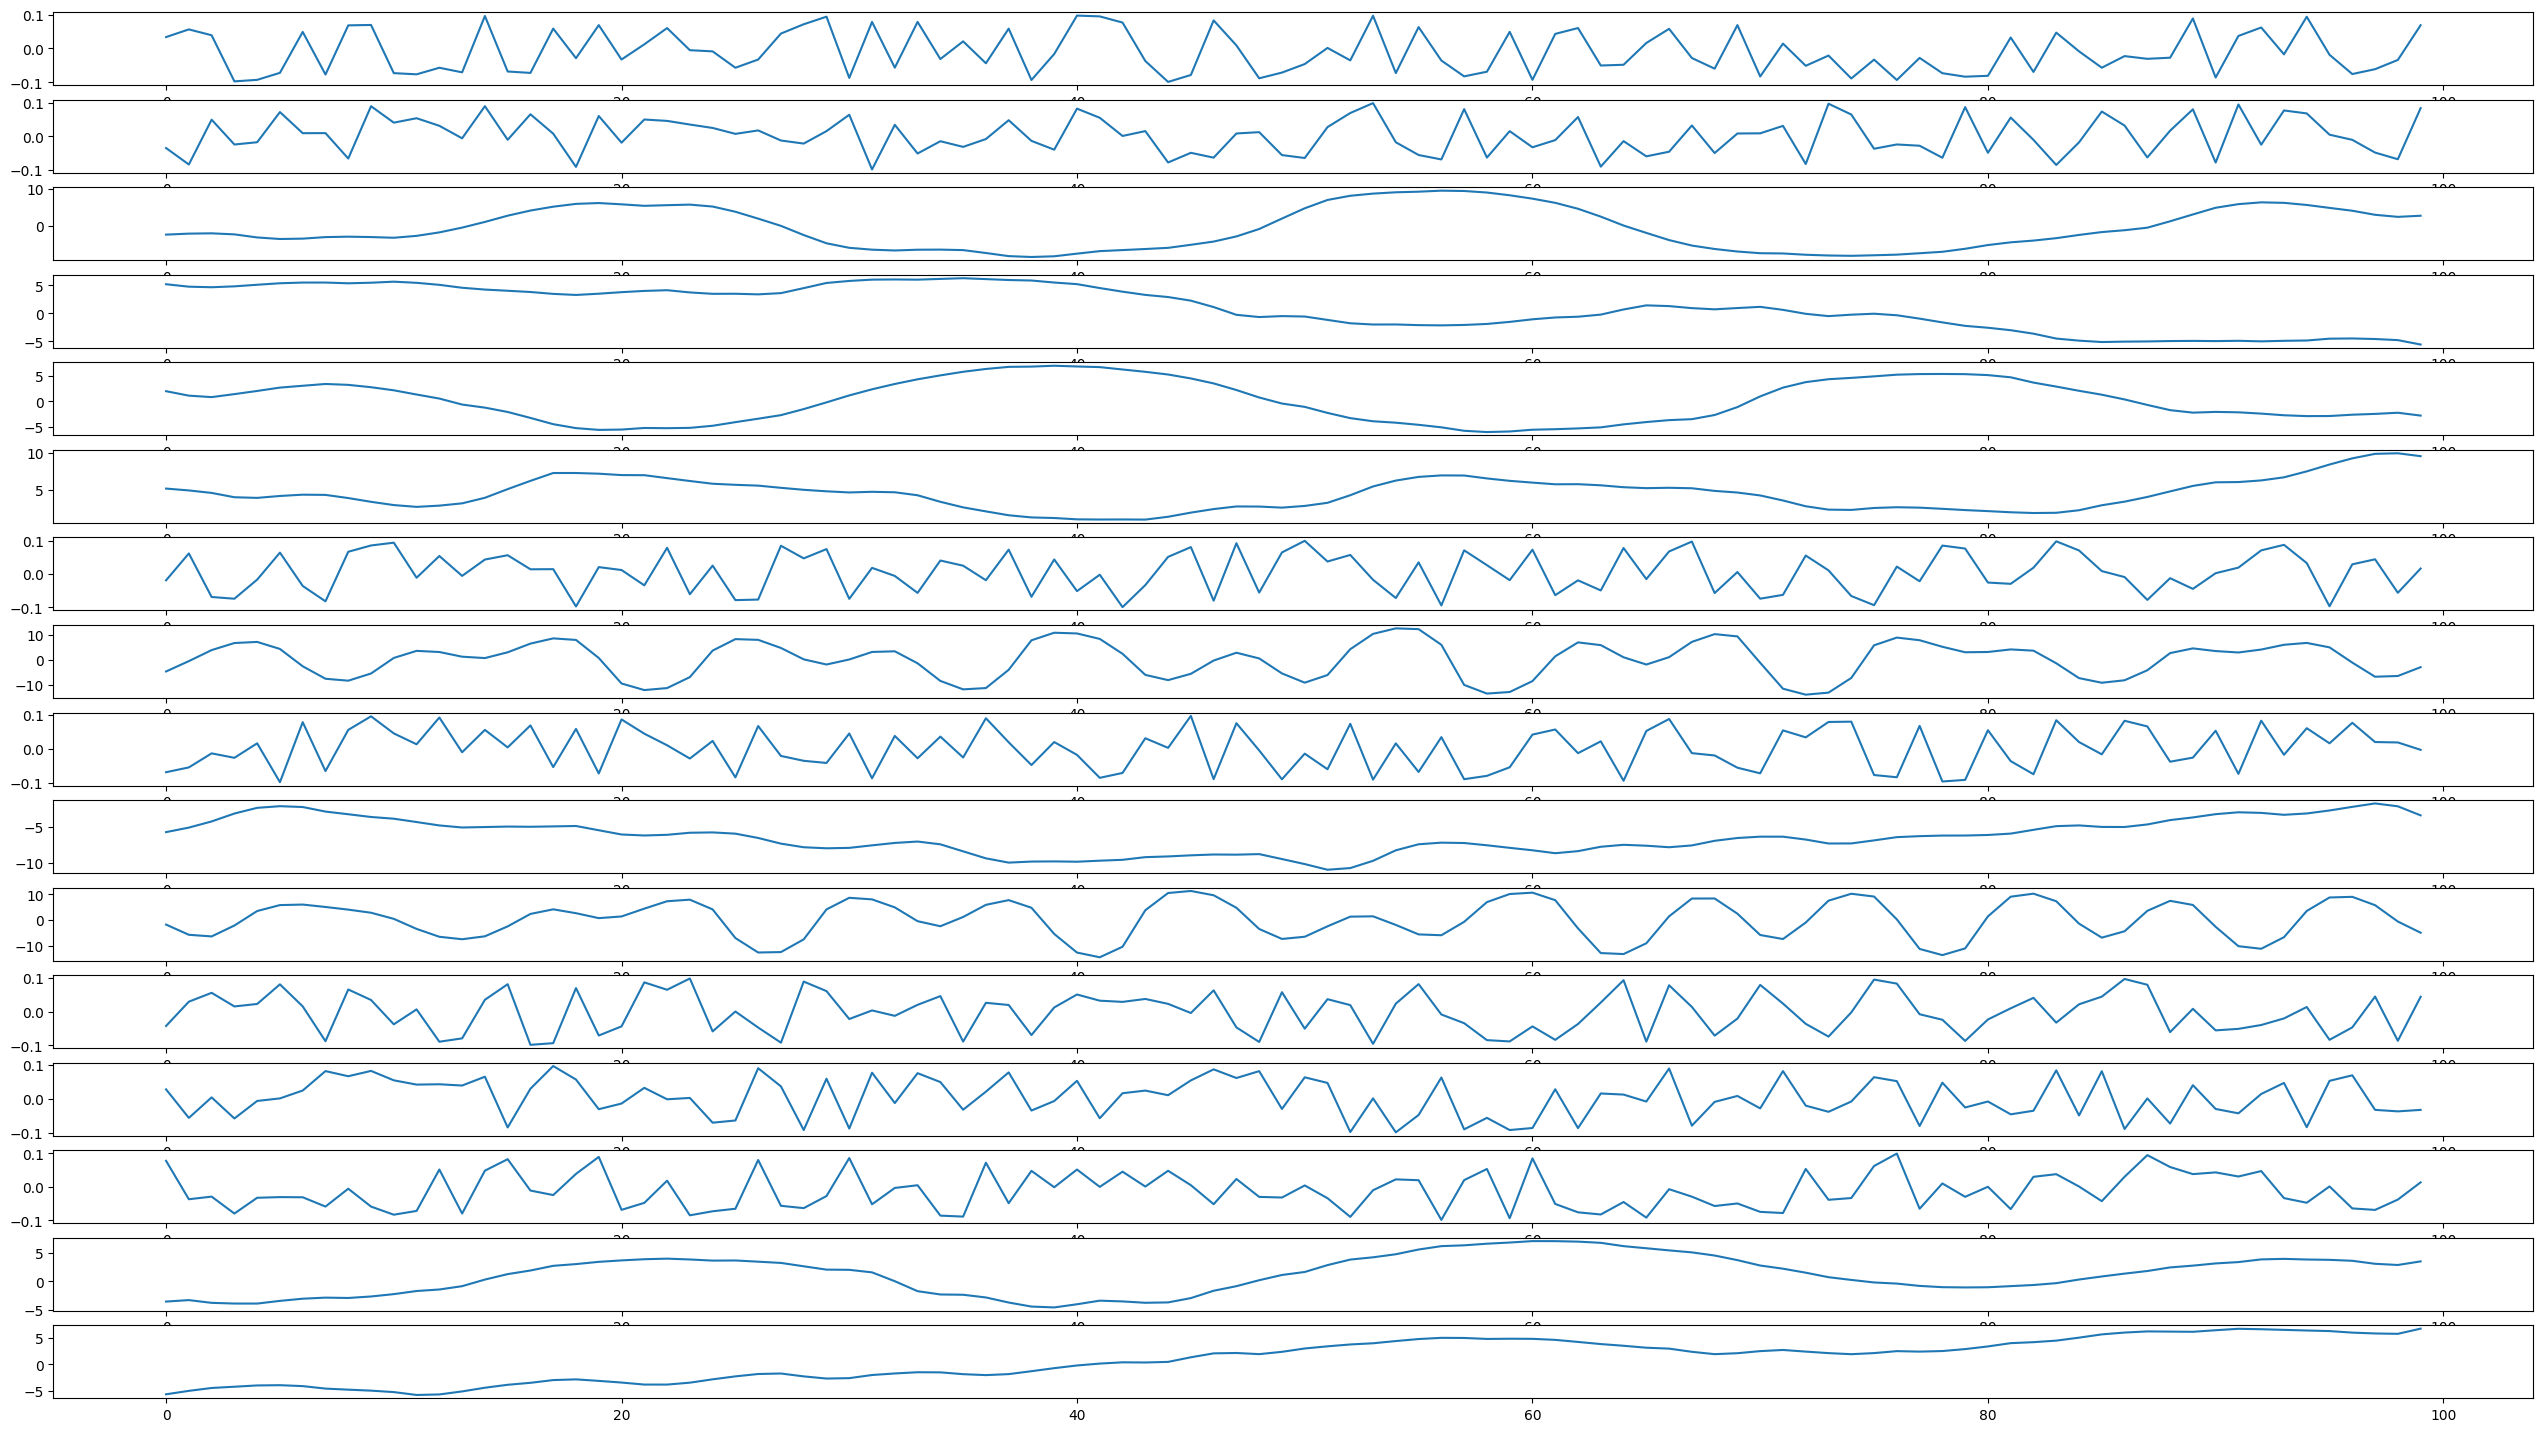

In [31]:
fig,axes = plt.subplots(nrows=len(model.c1.weight),ncols=1,figsize=(32,18))
for i in range(len(model.c1.weight)):
    axes[i].plot(model.c1.weight[i].squeeze().detach().cpu())
plt.savefig('figures/kernels.jpg',dpi=500)

In [ ]:
torch.save(obj=model,f='model.pt')